# NeuralNetworkモデル

- インスタンス生成, 初期化例
```python
NeuralNetwork(x_vals_train, y_vals_train, hidden_layers_info=[10, 5], act_func=['tanh','softmax'], 
              threshold=0.5, loss_func='absolute', optimizer='momentum', learning_rate=0.1, drop_out=0)
```
- x_vals_train: 訓練データ特徴(array)
- y_vals_train: 訓練データラベル(array)
- x_vals_test: テストデータ特徴(array)
- y_vals_test: テストデータラベル(array)

### 評価（とりあえず）
- Precision：複勝（3位以内）の馬の予測的中割合


In [1]:
import random
import pickle
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.examples.tutorials.mnist import input_data


np.random.seed(13)
train_size = 8
test_size = 2

version = 1
year = 2015
period = 3
with open("./keiba_data_ver{0}/keiba_feature_{1}".format(version, year), mode = "rb") as f:
    feature_arr = pickle.load(f)
    
with open("./keiba_data_ver{0}/keiba_label_{1}".format(version, year), mode = "rb") as f:
    label_arr = pickle.load(f)
    
for i in range(1, period-1):
    year = year + i
    with open("./keiba_data_ver{0}/keiba_feature_{1}".format(version, year), mode = "rb") as f:
        feature_arr = np.r_[feature_arr, pickle.load(f)]
    with open("./keiba_data_ver{0}/keiba_label_{1}".format(version, year), mode = "rb") as f:
        label_arr = np.r_[label_arr, pickle.load(f)]

/home/tsumita/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## train, testデータの分割
border = math.floor(len(feature_arr) * train_size / (train_size + test_size))

x_vals_train = feature_arr[:border]
x_vals_test = feature_arr[border:]
y_vals_train = label_arr[:border]
y_vals_test = label_arr[border:]

In [3]:
def under_sampling(data, label, us_rate=1):
    posi_data, nega_data = [], []
    
    for (x,y) in zip(data,label):
        if y[0] == 0:
            nega_data.append(x)
        else:
            posi_data.append(x)
            
    nega_len = int(len(posi_data) * us_rate)
    
    data = nega_data[0:nega_len] + posi_data
    label = [[0] for _ in range(nega_len)] + [[1] for _ in range(len(posi_data))]
    
    return np.array(data), np.array(label)

In [4]:
x_vals_train, y_vals_train = under_sampling(x_vals_train, y_vals_train)

In [5]:
nega_num = 0
posi_num = 0
for (x,y) in zip(x_vals_train, y_vals_train):
    if y[0] == 0:
        nega_num += 1
    else:
        posi_num += 1

In [6]:
## labelを2次元に
## 1=[1,0], 0=[0,1]
y_vals_train_2 = np.array([[y[0], (y[0]+1)%2]for y in y_vals_train])
y_vals_test_2 = np.array([[y[0], (y[0]+1)%2]for y in y_vals_test])

In [712]:
nega_num, posi_num

(6425, 6425)

In [695]:
x_vals_test[2], y_vals_test[0]

(array([0.875     , 0.72222222, 1.        , 0.        , 0.        ,
        3.        , 0.43333333, 0.415     , 8.        , 0.        ,
        0.        , 0.        , 0.02      , 0.97584   , 0.05769231,
        0.14423077, 2.08      , 1.        , 0.        , 0.        ,
        0.        , 0.32      , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        1.        , 0.25571667]), array([0]))

In [694]:
x_vals_test[11], y_vals_test[11]

(array([ 0.75      ,  0.61111111,  1.        ,  0.        ,  0.        ,
         5.        ,  0.56666667,  0.55      , -4.        ,  0.        ,
         0.        ,  0.        ,  0.02      ,  0.29635   ,  0.        ,
         0.10294118,  1.36      ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.24      ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.30858333]), array([1]))

In [7]:
posi_train_len = len([1 for y in y_vals_train_2 if y[0]==1])
posi_test_len = len([1 for y in y_vals_test if y[0]==1])
print("Train:{0:<5}, Posi:{1:<5}, Nega:{2:<5}".format(len(y_vals_train), posi_train_len, len(y_vals_train)-posi_train_len))
print("Test :{0:<5}, Posi:{1:<5}, Nega:{2:<5}".format(len(y_vals_test), posi_test_len, len(y_vals_test)-posi_test_len))

Train:33108, Posi:16554, Nega:16554
Test :19979, Posi:4190 , Nega:15789


In [35]:
class NeuralNetwork():
    def __init__(self, x_train_data, y_train_data, hidden_layers_info=[300, 100], threshold=0.5,
                  act_func=['relu','relu'], loss_func='absolute', optimizer='adam', learning_rate=0.05, drop_out=0):
        self.sess = tf.Session()
        self.x_train_data = x_train_data
        self.y_train_data = y_train_data
        self.input_size = len(x_train_data[0])
        self.output_size = len(y_train_data[0])
        self.layers_info = [self.input_size] + hidden_layers_info + [self.output_size]
        self.act_func = act_func
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.keep_prob_rate = 1 - drop_out
        
        self.create_placeholder()
        self.init_weights()
        
        self.set_model()        
        self.set_loss_func()
        self.set_optimize_func()
        self.train_step = self.my_opt.minimize(self.loss)
        
        ## 閾値
        self.threshold = threshold
        self.class_prediction = tf.to_float(tf.greater(self.final_output, self.threshold))
        self.correct_prediction = tf.equal((self.class_prediction), self.y_target)
        
        self.loss_vec = []
        self.test_loss = []
        self.train_precision = []
        self.test_precision = []
        self.train_accuracy = []
        self.test_accuracy = []
                
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', self.loss)
            self.merged = tf.summary.merge_all()
            self.writer = tf.summary.FileWriter('./logs', self.sess.graph)
        #変数を初期化
        self.init = tf.global_variables_initializer()
        self.sess.run(self.init)
        
    def init_weights(self):
        weight_shapes = [[self.layers_info[i], self.layers_info[i+1]] for i in range(len(self.layers_info) - 1)]
        self.weights = [tf.Variable(tf.random_normal(shape, stddev=10.), name='weight_layer'+str(i+1)) for i,shape in enumerate(weight_shapes)]
        bias_shapes = [[self.layers_info[i+1]] for i in range(len(self.layers_info) - 1)]
        self.biases = [tf.Variable(tf.random_normal(shape, stddev=10.), name='bias_layer'+str(i+1)) for i,shape in enumerate(bias_shapes)]
        
    def create_placeholder(self):
        self.x_data = tf.placeholder(shape=[None, self.input_size], dtype=tf.float32, name='input_data')
        self.y_target = tf.placeholder(shape=[None, self.output_size], dtype=tf.float32, name='labels')
        self.keep_prob = tf.placeholder(dtype=tf.float32)
        
    def fully_connected(self, input_layer, weights, biases):
        return tf.add(tf.matmul(input_layer, weights), biases)
    
    def activation_func(self, input_layer, func_name):
        if func_name == 'linear':
            return tf.nn.linear(input_layer)
        elif func_name == 'relu':
            return tf.nn.relu(input_layer)
        elif func_name == 'sigmoid':
            return tf.nn.sigmoid(input_layer)
        elif func_name == 'tanh':
            return tf.nn.tanh(input_layer)
        elif func_name == 'softsign':
            return tf.nn.softsign(input_layer)
        elif func_name == 'softmax':
            return tf.nn.softmax(input_layer)
        return input_layer
    
    def set_model(self):
        self.layers = [None] * (len(self.layers_info) - 1)
        self.layers[0] = self.x_data
        self.drop_out = [None] * (len(self.layers) - 1)
        
        for i in range(len(self.weights) - 1):
            with tf.name_scope('activation'+str(i+1)):
                if self.drop_out[0] == None:
                    self.layers[i+1] = self.activation_func(
                        self.fully_connected(self.layers[i], self.weights[i], self.biases[i]), 
                        self.act_func[0])
                else:
                    self.layers[i+1] = self.activation_func(
                        self.fully_connected(self.drop_out[i-1], self.weights[i], self.biases[i]), 
                        self.act_func[0])
                self.drop_out[i] = tf.nn.dropout(self.layers[i+1], self.keep_prob)
            
        with tf.name_scope('activation_fin'):
            self.final_output = self.activation_func(
                self.fully_connected(self.layers[-1], self.weights[-1], self.biases[-1]), 
                self.act_func[1])
            
        
    def set_loss_func(self):
        if self.loss_func == 'absolute':
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.abs(self.y_target - self.final_output))
        elif self.loss_func == 'euclidean':
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.square(self.y_target - self.final_output))
        elif self.loss_func == 'hinge':
            with tf.name_scope('loss'):
                self.loss = tf.reduce_mean(tf.maximum(0., 1. - tf.multiply(self.y_target, self.final_output)))
        elif self.loss_func == 'cross_entropy':
            with tf.name_scope('loss'):
                self.loss = - tf.reduce_mean(tf.multiply(self.y_target, tf.log(self.final_output)) +
                                         tf.multiply((1. - self.y_target), tf.log(1. - self.final_output)))
    
    def set_optimize_func(self):
        if self.optimizer == 'sgd':
            self.my_opt = tf.train.GradientDescentOptimizer(self.learning_rate)
        elif self.optimizer == 'momentum':
            self.my_opt = tf.train.MomentumOptimizer(self.learning_rate, momentum=0.9)
        elif self.optimizer == 'adam':
            self.my_opt = tf.train.AdamOptimizer(self.learning_rate)
        elif self.optimizer == 'adagrad':
            self.my_opt = tf.train.AdagradOptimizer(self.learning_rate)
        elif self.optimizer == 'adadelta':
            self.my_opt = tf.train.AdadeltaOptimizer(self.learning_rate)
        elif self.optimizer == 'rmsprop':
            self.my_opt = tf.train.RMSPropOptimizer(self.learning_rate)
            
    def sepate_label_data(self, x_test_data, y_test_data):
        self.true_feature = np.array([x_test_data[i] for i in range(len(x_test_data)) if y_test_data[i][0]==1])
        self.ture_label = np.array([y_test_data[i] for i in range(len(x_test_data)) if y_test_data[i][0]==1])
        self.false_feature = np.array([x_test_data[i] for i in range(len(x_test_data)) if y_test_data[i][0]==0])
        self.false_label = np.array([y_test_data[i] for i in range(len(x_test_data)) if y_test_data[i][0]==0])
        self.true_data_num = len(self.true_label)
        self.false_data_num = len(self.false_label)
            
    def classification(self, x_test_data, y_test_data):
        self.prob = self.final_output.eval(session=self.sess, feed_dict={self.x_data: x_test_data, self.keep_prob: 1})
        self.real_num = self.class_prediction.eval(session=self.sess, feed_dict={self.x_data: x_test_data, self.keep_prob: 1})
        tp = len([1 for i in range(len(self.real_num)) if (self.real_num[i]==1 and self.real_num[i]==y_test_data[i])])
        fp = len([1 for i in range(len(self.real_num)) if (self.real_num[i]==1 and self.real_num[i]!=y_test_data[i])])
        fn = len([1 for i in range(len(self.real_num)) if (self.real_num[i]==0 and self.real_num[i]!=y_test_data[i])])
        tn = len([1 for i in range(len(self.real_num)) if (self.real_num[i]==0 and self.real_num[i]==y_test_data[i])])
        print("-"*16)
        print("TP:{0:<4}|FP:{1:<4}".format(tp, fp))
        print("FN:{0:<4}|TN:{1:<4}".format(fn, tn))
        print("-"*16)
        if (tp + fp)==0 or (tp + fn)==0:
            return
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        if (precision + recall)==0:
            return
        f_score = 2*precision*recall / (precision + recall)
        print("Precision:{0:<4}, Recall:{1:<4}, F-score:{2:<4}".format(precision, recall, f_score))
        self.precision.append(precision)
        
    def classification_softmax(self, x_test_data, y_test_data):
        self.prob = self.final_output.eval(session=self.sess, feed_dict={self.x_data: x_test_data, self.keep_prob: 1})
        self.real_num = self.sess.run(tf.argmin(self.prob, 1))
        y_test_data = self.sess.run(tf.argmin(y_test_data, 1))
        
        tp = len([1 for i in range(len(self.real_num)) if (self.real_num[i]==1 and self.real_num[i]==y_test_data[i])])
        fp = len([1 for i in range(len(self.real_num)) if (self.real_num[i]==1 and self.real_num[i]!=y_test_data[i])])
        fn = len([1 for i in range(len(self.real_num)) if (self.real_num[i]==0 and self.real_num[i]!=y_test_data[i])])
        tn = len([1 for i in range(len(self.real_num)) if (self.real_num[i]==0 and self.real_num[i]==y_test_data[i])])
        print("-"*16)
        print("TP:{0:<5}|FP:{1:<5}".format(tp, fp))
        print("FN:{0:<5}|TN:{1:<5}".format(fn, tn))
        print("-"*16)
        if (tp + fp)==0 or (tp + fn)==0:
            return
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        if (precision + recall)==0:
            return
        f_score = 2*precision*recall / (precision + recall)
        print("Precision:{0:<4}, Recall:{1:<4}, F-score:{2:<4}".format(precision, recall, f_score))
#         self.precision.append(precision)
#         self.accuracy.append((tp+tn)/(fp+fn))
        return precision, (tp+tn)/(tp+tn+fp+fn)
    
    def train0(self, x_test_data, y_test_data, batch_size=10, epoch=100):
        true_num = len([1 for label in y_test_data if label[0]==1])
        false_num = len(y_test_data) - true_num
        print("True:{0:4}, False:{1:4}".format(true_num, false_num))
        
        self.batch_size = batch_size
        self.epoch = epoch
        
        for i in range(self.epoch):
            rand_index = np.random.choice(len(self.x_train_data), size=self.batch_size)
            rand_x = self.x_train_data[rand_index]
            rand_y = self.y_train_data[rand_index]

            self.sess.run(self.final_output, feed_dict={self.x_data: rand_x, self.y_target: rand_y})
            
            self.sess.run(self.train_step, feed_dict={self.x_data: rand_x, self.y_target: rand_y})

            temp_loss = self.sess.run(self.loss, feed_dict={self.x_data: rand_x, self.y_target: rand_y})
            self.loss_vec.append(temp_loss)

            test_temp_loss = self.sess.run(self.loss, feed_dict={self.x_data: x_test_data, self.y_target: y_test_data})
            self.test_loss.append(test_temp_loss)
            
            if self.threshold != None:
                self.classification(x_test_data, y_test_data)

            if (i+1)%1 == 0:
                print('Generation: ' + str(i+1) + ' , Loss = ' + str(temp_loss))
                
            print("="*30)
            print("\n")
            
    def train(self, x_test_data, y_test_data, batch_size=10, epoch=100, softmax=True):
        true_num = len([1 for label in y_test_data if label[0]==1])
        false_num = len(y_test_data) - true_num
        print("True:{0:4}, False:{1:4}".format(true_num, false_num))
        
        self.batch_size = batch_size
        self.n_batches = len(x_test_data) // self.batch_size
        self.epoch = epoch
        
        for i in range(self.epoch):
            random_train_data = np.random.permutation(len(self.x_train_data))
            for batch_i in range(self.n_batches):
                start = batch_i * self.batch_size
                end = start + self.batch_size
                rand_index = random_train_data[start:end]
                rand_x = self.x_train_data[rand_index]
                rand_y = self.y_train_data[rand_index]

#                 self.sess.run(self.final_output, feed_dict={self.x_data: rand_x, self.y_target: rand_y})

                self.sess.run(self.train_step, feed_dict={self.x_data: rand_x, self.y_target: rand_y, self.keep_prob: self.keep_prob_rate})

                temp_loss = self.sess.run(self.loss, feed_dict={self.x_data: rand_x, self.y_target: rand_y, self.keep_prob: 1})
                test_temp_loss = self.sess.run(self.loss, feed_dict={self.x_data: x_test_data, self.y_target: y_test_data, self.keep_prob: 1})
                
            self.loss_vec.append(temp_loss)
            self.test_loss.append(test_temp_loss)

            if self.threshold != None and softmax==True:
#                 self.classification(x_test_data, y_test_data)
                precision, accuracy = self.classification_softmax(x_test_data, y_test_data)
                self.test_precision.append(precision)
                self.test_accuracy.append(accuracy)
                precision, accuracy = self.classification_softmax(self.x_train_data, self.y_train_data)
                self.train_accuracy.append(accuracy)
                self.train_precision.append(precision)

            if (i+1)%1 == 0:
                print('Generation: ' + str(i+1) + ' , Loss = ' + str(temp_loss))
                
            print("="*30)
            print("\n")
            
    def test(self, x_test_data, y_test_data):
        ## テストのみ：精度を返したい
        self.test_only_loss = []
        test_temp_loss = self.sess.run(self.loss, feed_dict={self.x_data: x_test_data, self.y_target: y_test_data, self.keep_prob: 1})
        self.test_only_loss.append(test_temp_loss)
        
    def prediction(self, x_test_data):
        ## 予測に関して：1レースの出走馬情報（特徴量）を入力にランキングを返したい
        return
                
    def get_loss_vec(self):
        return self.loss_vec, self.test_loss, self.train_precision, self.test_precision, self.prob, self.train_accuracy, self.test_accuracy
    
    def get_ae_loss_vec(self):
        return self.loss_vec, self.test_loss
    

### AutoEncoder

In [21]:
my_ae_model = NeuralNetwork(x_vals_train, x_vals_train, hidden_layers_info=[20, 10, 20], act_func=['tanh','softsign'], 
                            threshold=0.5, loss_func='absolute', optimizer='sgd', learning_rate=0.05, drop_out=0)

In [23]:
my_ae_model.train(x_vals_test, x_vals_test, batch_size=100, epoch=100, softmax=False)

True:2929, False:17050
Generation: 1 , Loss = 1.0991336


Generation: 2 , Loss = 1.1248417


Generation: 3 , Loss = 1.121429


Generation: 4 , Loss = 1.1313486


Generation: 5 , Loss = 1.0994444


Generation: 6 , Loss = 1.1306994


Generation: 7 , Loss = 1.1062071


Generation: 8 , Loss = 1.1259906


Generation: 9 , Loss = 1.106078


Generation: 10 , Loss = 1.1269184


Generation: 11 , Loss = 1.1392294


Generation: 12 , Loss = 1.0917193


Generation: 13 , Loss = 1.1078699


Generation: 14 , Loss = 1.1080066


Generation: 15 , Loss = 1.1119213


Generation: 16 , Loss = 1.1279367


Generation: 17 , Loss = 1.1196327


Generation: 18 , Loss = 1.1148123


Generation: 19 , Loss = 1.1171533


Generation: 20 , Loss = 1.108108


Generation: 21 , Loss = 1.1118491


Generation: 22 , Loss = 1.1374022


Generation: 23 , Loss = 1.1015067


Generation: 24 , Loss = 1.1007605


Generation: 25 , Loss = 1.1042869


Generation: 26 , Loss = 1.11153


Generation: 27 , Loss = 1.1062434


Generation: 28 , Lo

### 出力層1 - sigmoid

In [38]:
my_neural_model = NeuralNetwork(x_vals_train, y_vals_train, hidden_layers_info=[30, 20, 10, 5], act_func=['tanh','softsign'], 
                                threshold=0.5, loss_func='absolute', optimizer='adam', learning_rate=0.05, drop_out=0)

In [641]:
my_neural_model.train0(x_vals_test, y_vals_test, batch_size=100, epoch=5)

True:4190, False:15789


ValueError: Cannot feed value of shape (19979, 1) for Tensor 'labels_111:0', which has shape '(?, 2)'

### 出力層2 - softmax

In [39]:
my_neural_model = NeuralNetwork(x_vals_train, y_vals_train_2, hidden_layers_info=[10, 5], act_func=['tanh','softmax'], 
                                threshold=0.5, loss_func='absolute', optimizer='momentum', learning_rate=0.1, drop_out=0)

In [40]:
my_neural_model.train(x_vals_test, y_vals_test_2, batch_size=20, epoch=80)

True:4190, False:15789
----------------
TP:1140 |FP:4813 
FN:3050 |TN:10976
----------------
Precision:0.19150008399126492, Recall:0.2720763723150358, F-score:0.22478556640047323
----------------
TP:5854 |FP:6942 
FN:10700|TN:9612 
----------------
Precision:0.45748671459831197, Recall:0.3536305424670774, F-score:0.3989097103918228
Generation: 1 , Loss = 0.5


----------------
TP:1179 |FP:4929 
FN:3011 |TN:10860
----------------
Precision:0.19302554027504912, Recall:0.2813842482100239, F-score:0.22897650029131872
----------------
TP:5982 |FP:7076 
FN:10572|TN:9478 
----------------
Precision:0.4581099708990657, Recall:0.3613628126132657, F-score:0.4040253951100905
Generation: 2 , Loss = 0.54999995


----------------
TP:1718 |FP:6716 
FN:2472 |TN:9073 
----------------
Precision:0.2036993123073275, Recall:0.4100238663484487, F-score:0.27217997465145755
----------------
TP:8349 |FP:9330 
FN:8205 |TN:7224 
----------------
Precision:0.4722552180553199, Recall:0.5043494019572309, F-score:0

----------------
TP:2106 |FP:8149 
FN:2084 |TN:7640 
----------------
Precision:0.2053632374451487, Recall:0.5026252983293557, F-score:0.29158878504672897
----------------
TP:9787 |FP:10458
FN:6767 |TN:6096 
----------------
Precision:0.4834280069152877, Recall:0.5912166243808143, F-score:0.5319166281692438
Generation: 23 , Loss = 0.45000058


----------------
TP:2106 |FP:8149 
FN:2084 |TN:7640 
----------------
Precision:0.2053632374451487, Recall:0.5026252983293557, F-score:0.29158878504672897
----------------
TP:9787 |FP:10458
FN:6767 |TN:6096 
----------------
Precision:0.4834280069152877, Recall:0.5912166243808143, F-score:0.5319166281692438
Generation: 24 , Loss = 0.4


----------------
TP:2106 |FP:8149 
FN:2084 |TN:7640 
----------------
Precision:0.2053632374451487, Recall:0.5026252983293557, F-score:0.29158878504672897
----------------
TP:9787 |FP:10458
FN:6767 |TN:6096 
----------------
Precision:0.4834280069152877, Recall:0.5912166243808143, F-score:0.5319166281692438
Genera

----------------
TP:2106 |FP:8150 
FN:2084 |TN:7639 
----------------
Precision:0.20534321372854913, Recall:0.5026252983293557, F-score:0.2915686003045826
----------------
TP:9788 |FP:10458
FN:6766 |TN:6096 
----------------
Precision:0.4834535216832955, Recall:0.5912770327413314, F-score:0.5319565217391304
Generation: 45 , Loss = 0.55


----------------
TP:2106 |FP:8150 
FN:2084 |TN:7639 
----------------
Precision:0.20534321372854913, Recall:0.5026252983293557, F-score:0.2915686003045826
----------------
TP:9789 |FP:10458
FN:6765 |TN:6096 
----------------
Precision:0.4834790339309527, Recall:0.5913374411018485, F-score:0.5319964131409473
Generation: 46 , Loss = 0.55000067


----------------
TP:2106 |FP:8150 
FN:2084 |TN:7639 
----------------
Precision:0.20534321372854913, Recall:0.5026252983293557, F-score:0.2915686003045826
----------------
TP:9790 |FP:10458
FN:6764 |TN:6096 
----------------
Precision:0.48350454365863293, Recall:0.5913978494623656, F-score:0.5320363023748709
Gene

----------------
TP:2107 |FP:8150 
FN:2083 |TN:7639 
----------------
Precision:0.20542068831042215, Recall:0.5028639618138425, F-score:0.2916868554025057
----------------
TP:9791 |FP:10458
FN:6763 |TN:6096 
----------------
Precision:0.48353005086670947, Recall:0.5914582578228826, F-score:0.5320761894410782
Generation: 67 , Loss = 0.60000026


----------------
TP:2107 |FP:8150 
FN:2083 |TN:7639 
----------------
Precision:0.20542068831042215, Recall:0.5028639618138425, F-score:0.2916868554025057
----------------
TP:9791 |FP:10458
FN:6763 |TN:6096 
----------------
Precision:0.48353005086670947, Recall:0.5914582578228826, F-score:0.5320761894410782
Generation: 68 , Loss = 0.40000024


----------------
TP:2107 |FP:8150 
FN:2083 |TN:7639 
----------------
Precision:0.20542068831042215, Recall:0.5028639618138425, F-score:0.2916868554025057
----------------
TP:9791 |FP:10458
FN:6763 |TN:6096 
----------------
Precision:0.48353005086670947, Recall:0.5914582578228826, F-score:0.5320761894410

In [27]:
loss_vec, test_loss, train_precision, test_precision, prob, train_acc, test_acc = my_neural_model.get_loss_vec()

In [568]:
prob

array([[7.0219894e-16, 1.0000000e+00],
       [7.0219894e-16, 1.0000000e+00],
       [7.0219894e-16, 1.0000000e+00],
       ...,
       [1.3429876e-12, 1.0000000e+00],
       [3.8214218e-10, 1.0000000e+00],
       [7.0219894e-16, 1.0000000e+00]], dtype=float32)

In [430]:
for i in prob:
    if i != 0 and i != 1 and i!=-1:
        print(i)

[0.07290005]
[0.08602668]
[0.07290005]
[0.0729771]
[0.07686429]
[0.08602668]
[0.07290005]
[0.07704143]
[0.07290005]
[-0.8952139]
[-0.9694816]
[0.08602668]
[0.07705605]
[0.07290005]
[0.07290333]
[0.08602668]
[0.07704143]
[0.07704143]
[0.07290005]
[0.07290005]
[0.07290005]
[0.07704143]
[0.08602668]
[0.08602668]
[-0.9585597]
[0.08602668]
[0.08602668]
[0.08602668]
[-0.9694816]
[0.0770333]
[0.08602668]
[-0.9694816]
[-0.9694816]
[0.07290005]
[0.07290005]
[-0.9694816]
[0.07290005]
[0.07290005]
[-0.96948147]
[0.07704143]
[-0.9257341]
[0.07290005]
[-0.9377626]
[0.08457687]
[-0.9585572]
[0.08602668]
[-0.9694816]
[0.07290005]
[0.0770463]
[0.07704143]
[-0.9585572]
[0.07704143]
[-0.9585597]
[0.07686429]
[0.08602668]
[0.07290005]
[0.07704143]
[0.07690168]
[0.08548384]
[-0.9257289]
[-0.9717318]
[-0.9585597]
[0.08602668]
[-0.9585572]
[0.07691305]
[0.07704143]
[0.07290005]
[-0.9585597]
[-0.9694816]
[0.07290005]
[0.07685129]
[0.07290005]
[0.07290005]
[0.07290005]
[-0.9585572]
[0.07704143]
[0.07693906]
[

[-0.9585597]
[-0.9694816]
[-0.9585572]
[0.0770463]
[0.07704143]
[0.07704143]
[0.07290005]
[0.07290005]
[0.07290005]
[0.07704143]
[0.08602668]
[-0.9694816]
[0.08602668]
[0.07290005]
[0.07686429]
[0.07290005]
[-0.9694816]
[0.07290333]
[-0.9585572]
[0.07290005]
[-0.9377627]
[-0.9694816]
[0.07686429]
[0.07686429]
[0.07686429]
[0.07290005]
[0.07686429]
[0.07290005]
[-0.9694816]
[0.07290005]
[0.07704143]
[0.07686429]
[0.07693581]
[-0.9694816]
[0.08602668]
[0.07290005]
[0.07290005]
[-0.9585594]
[-0.89521396]
[-0.9257338]
[-0.8952138]
[0.08602668]
[0.07290005]
[0.07290005]
[0.07290005]
[0.07704143]
[0.07704143]
[0.07686429]
[-0.9713727]
[-0.895214]
[-0.96869063]
[-0.93091303]
[0.07704468]
[0.07704468]
[0.07704468]
[0.07290005]
[-0.9377626]
[0.07704143]
[-0.9257338]
[-0.9585572]
[-0.9585572]
[0.08458007]
[-0.9585572]
[0.07290005]
[-0.96948147]
[0.07290005]
[0.08602668]
[-0.9585572]
[-0.9694816]
[-0.9585572]
[-0.9694816]
[0.07290005]
[0.08602668]
[-0.97173184]
[0.08602668]
[0.07290005]
[-0.96948

[0.08602668]
[-0.9694816]
[0.07704143]
[0.07290005]
[0.08602668]
[0.07290005]
[0.08602668]
[-0.9694816]
[0.07290005]
[-0.9694816]
[0.07290005]
[-0.9257288]
[-0.9585572]
[0.0770528]
[0.07290005]
[0.07290005]
[0.07708529]
[0.07290005]
[-0.9585597]
[0.07706743]
[-0.9694816]
[0.0770658]
[0.07704468]
[-0.9585597]
[0.07290005]
[0.07704468]
[0.07290005]
[0.07704468]
[-0.9694816]
[0.08602668]
[0.07692768]
[0.07703656]
[-0.9585572]
[0.07290005]
[0.07704793]
[0.07704143]
[-0.9694816]
[-0.9694816]
[-0.9694816]
[-0.9585572]
[0.08602668]
[-0.9585572]
[-0.9717318]
[-0.925731]
[-0.9694816]
[0.07286398]
[0.07704143]
[0.07290005]
[-0.9694816]
[0.08602668]
[0.07290005]
[0.07290005]
[0.07704468]
[0.07704468]
[0.07704468]
[0.07701381]
[-0.89521396]
[0.07683992]
[0.07704468]
[-0.91766846]
[0.07704468]
[-0.9667318]
[-0.9377627]
[-0.9686752]
[-0.9585572]
[0.07701381]
[0.07700893]
[0.07290005]
[-0.9585572]
[-0.9585572]
[0.07701381]
[0.07704143]
[0.07290005]
[0.07686429]
[0.07690005]
[0.07604925]
[-0.9257341]


[-0.9185251]
[0.07704955]
[0.07290005]
[0.07290005]
[0.07290005]
[0.07704468]
[-0.9585597]
[0.08457927]
[0.08602668]
[0.07704143]
[0.07290005]
[-0.9377627]
[-0.8952138]
[-0.9694816]
[0.08602668]
[-0.9585597]
[-0.9585572]
[-0.9585597]
[-0.9585597]
[-0.9585597]
[0.07704143]
[0.07290005]
[0.08602668]
[0.07290005]
[-0.8952138]
[0.07704143]
[0.08602668]
[0.07704143]
[-0.9585603]
[0.07704468]
[-0.9585597]
[0.07703818]
[-0.9257315]
[0.07705767]
[0.07290005]
[0.08602668]
[-0.9694816]
[0.08602668]
[-0.9377627]
[0.0770463]
[-0.9694816]
[0.07290005]
[0.07704143]
[0.07290005]
[0.07290005]
[0.07290005]
[0.07290005]
[0.08602668]
[-0.95856065]
[-0.8942384]
[0.07290005]
[0.07290005]
[0.07704143]
[0.07290005]
[0.07704143]
[0.07290005]
[-0.9585597]
[0.07290333]
[0.07290005]
[0.07290005]
[-0.9113645]
[0.07704143]
[0.07704143]
[0.07290005]
[0.07704143]
[0.07290005]
[0.08602668]
[0.08602668]
[0.08602668]
[0.08602668]
[0.07290005]
[0.08602668]
[-0.9694816]
[0.07760164]
[0.08457767]
[0.08602668]
[0.08602668]

[0.07290005]
[0.07686592]
[0.08602668]
[-0.95856065]
[-0.9585597]
[0.07362246]
[0.07704143]
[0.07704143]
[0.08602668]
[0.07686429]
[-0.9585597]
[0.0770463]
[0.08602668]
[0.08602668]
[0.08602668]
[-0.9585661]
[0.08602668]
[-0.89521176]
[-0.9585606]
[-0.9585601]
[-0.9585652]
[0.08602668]
[-0.9585598]
[0.08602668]
[-0.9585595]
[0.08602668]
[0.08602668]
[0.08602668]
[0.08602668]
[0.08602668]
[-0.9585459]
[-0.9585572]
[0.08602668]
[0.0770463]
[-0.96948147]
[0.07702356]
[0.07704143]
[0.07290005]
[0.07686429]
[0.08602668]
[-0.9694816]
[0.07290005]
[-0.9585597]
[0.07290005]
[0.07290989]
[0.07290005]
[0.07704143]
[0.07290005]
[0.08602668]
[0.08602668]
[-0.9717318]
[0.0770463]
[0.07704143]
[0.07290005]
[-0.91734356]
[-0.9172627]
[0.08602668]
[-0.9694816]
[0.08602668]
[0.07704143]
[0.07704143]
[-0.9694816]
[0.08602668]
[-0.83245647]
[0.07704143]
[0.07704143]
[0.07704143]
[0.07290005]
[0.07704143]
[0.08602668]
[0.07704143]
[0.07704143]
[-0.89505506]
[0.08602668]
[0.07305085]
[-0.9585597]
[0.086026

[-0.9585597]
[0.07704143]
[0.07704306]
[0.08602668]
[0.08602668]
[0.07290005]
[0.08602668]
[-0.8952138]
[0.07704143]
[0.07290005]
[0.07704143]
[0.08481816]
[0.07290005]
[-0.9377627]
[0.07706743]
[0.07290005]
[0.08602668]
[0.08602668]
[-0.9694816]
[0.07704306]
[0.07703981]
[0.07704143]
[-0.9694816]
[0.07290169]
[0.07290005]
[0.08602668]
[0.07290005]
[-0.9585597]
[0.07290005]
[-0.9585597]
[0.08602668]
[0.08602668]
[0.07290005]
[0.07290005]
[0.07704143]
[0.0787613]
[0.07704143]
[0.07290005]
[0.07290005]
[0.07290005]
[-0.97173184]
[0.07290005]
[0.08602668]
[0.07290333]
[-0.9585661]
[-0.9585572]
[-0.9585597]
[0.07290005]
[-0.9585597]
[0.07704143]
[-0.9585597]
[-0.9694816]
[0.07290005]
[0.08602668]
[0.07290005]
[0.07292956]
[0.07290005]
[0.07292628]
[0.07702356]
[0.07704143]
[-0.9585572]
[-0.9694816]
[0.07290005]
[0.07704143]
[-0.9585597]
[0.08602668]
[0.08501222]
[0.07290005]
[0.07290005]
[0.08602668]
[-0.95855975]
[0.07290005]
[-0.9027947]
[-0.9694816]
[0.07290005]
[0.08457927]
[-0.9585597

[-0.9185274]
[0.07290005]
[0.07290005]
[-0.9585597]
[-0.91852504]
[-0.9377626]
[0.07290005]
[0.07290005]
[0.08602668]
[0.08602668]
[0.08458007]
[0.08458007]
[0.08602668]
[0.07290005]
[0.07290825]
[-0.9585597]
[0.07704468]
[0.08457448]
[0.07290005]
[0.07290005]
[-0.9585597]
[0.07704468]
[-0.97173184]
[0.07703981]
[-0.97173184]
[0.07290005]
[-0.9585597]
[0.08602668]
[0.08332285]
[-0.9694816]
[0.08602668]
[-0.97173184]
[0.07290005]
[0.08602668]
[-0.9377627]
[0.07290005]
[-0.9694816]
[-0.9585572]
[-0.9585597]
[-0.9694816]
[0.07703981]
[0.08602668]
[0.08458486]
[0.07332283]
[0.07704143]
[0.07704143]
[0.07290005]
[-0.97173184]
[-0.9694816]
[0.07290005]
[0.08602668]
[0.08602668]
[-0.9694816]
[0.08458007]
[-0.9585597]
[0.08458007]
[0.08602668]
[0.08458007]
[-0.9585597]
[0.08602668]
[0.07290005]
[-0.9585597]
[0.07704468]
[0.07290005]
[0.08602668]
[-0.9585599]
[-0.97173184]
[0.07704143]
[0.08602668]
[0.08602668]
[-0.97173184]
[-0.9585597]
[-0.9717223]
[0.08458007]
[-0.97173184]
[0.08602668]
[0.0

[-0.9377627]
[-0.9694816]
[0.07704306]
[-0.9257288]
[-0.9377626]
[-0.9185251]
[-0.9377627]
[0.07700568]
[-0.9694816]
[0.07290005]
[-0.9377627]
[-0.9377626]
[0.08457367]
[-0.9694816]
[0.07290333]
[0.0770463]
[-0.9377627]
[0.07704143]
[0.08602668]
[0.07290005]
[0.08602668]
[0.07290005]
[0.08021586]
[0.07704468]
[0.07704468]
[-0.9377627]
[0.07748316]
[0.07702356]
[-0.97173184]
[0.0729689]
[0.07704143]
[0.07290005]
[0.07704468]
[0.0770463]
[0.07290005]
[0.07286726]
[-0.97173184]
[0.0770463]
[0.07290005]
[0.07688867]
[-0.9377627]
[0.07290005]
[0.07290005]
[-0.9694816]
[0.07704468]
[0.08602668]
[0.07290005]
[-0.97173184]
[-0.9585572]
[0.07290005]
[-0.9694816]
[-0.9585572]
[0.07290005]
[0.07704143]
[0.07290005]
[0.07290005]
[-0.9257338]
[0.07290005]
[0.07704468]
[0.07697156]
[-0.9585597]
[-0.9694816]
[0.07290005]
[-0.9694816]
[0.07290005]
[-0.9694816]
[0.08602668]
[0.07290005]
[-0.9694815]
[-0.9717318]
[0.07290005]
[-0.92572814]
[-0.97173184]
[-0.925729]
[-0.9257315]
[-0.9257323]
[0.08602668]

[0.07704468]
[-0.9585572]
[0.07704468]
[0.07290005]
[0.07290005]
[0.07290005]
[-0.9694816]
[-0.9377627]
[-0.9694816]
[-0.9694816]
[0.07704468]
[0.07290005]
[-0.91852546]
[0.08602668]
[0.07290005]
[0.07290005]
[-0.97173184]
[0.07290005]
[0.08602668]
[0.07686592]
[-0.9694816]
[0.07704143]
[0.07704143]
[0.07704468]
[0.08602668]
[-0.9694816]
[0.07704468]
[-0.9377627]
[-0.9257312]
[0.07704468]
[-0.9694816]
[-0.9694816]
[0.07704143]
[0.07290005]
[-0.9585572]
[0.07704468]
[0.07290005]
[0.07290005]
[-0.9694816]
[0.07290005]
[0.07290005]
[0.07686429]
[0.07704143]
[0.07290005]
[-0.97173184]
[0.07290005]
[0.08457927]
[0.07705443]
[0.08457847]
[0.07704143]
[0.07704143]
[-0.96948147]
[-0.97173184]
[0.07704468]
[0.07704143]
[-0.97173184]
[0.0770333]
[-0.92573357]
[-0.9694816]
[-0.9694816]
[-0.9694816]
[-0.9585597]
[0.07637398]
[0.07704468]
[0.0729984]
[0.08457367]
[0.08602668]
[-0.97173184]
[0.08602668]
[0.07704143]
[0.08602668]
[-0.9585597]
[-0.8952138]
[0.07290005]
[-0.97173184]
[0.08458007]
[-0.9

[-0.9685303]
[0.07704468]
[0.07704468]
[-0.89521396]
[-0.95604175]
[-0.91767085]
[0.07704143]
[-0.9694816]
[0.07704468]
[0.08602668]
[0.07704143]
[-0.9694816]
[0.07290005]
[0.07290005]
[0.07290005]
[0.07290005]
[0.07704143]
[-0.9694816]
[0.07704143]
[0.07704143]
[-0.9377627]
[0.07704143]
[0.07290005]
[0.07686592]
[-0.9585597]
[0.07290005]
[0.08602668]
[0.07704468]
[0.07290005]
[0.07704143]
[0.07290169]
[0.08602668]
[0.0770463]
[0.08602668]
[-0.9585597]
[0.07290005]
[0.08602668]
[-0.9377627]
[0.08602668]
[-0.9585597]
[0.07290005]
[-0.9585572]
[0.08602668]
[-0.9694816]
[0.08602668]
[0.07290005]
[-0.9694816]
[0.07290005]
[0.07698619]
[0.07290005]
[0.07704143]
[-0.9585572]
[0.07704468]
[-0.9257288]
[0.07704468]
[0.07704468]
[0.07704468]
[0.07290005]
[0.07290005]
[0.08602668]
[0.07704143]
[0.07704468]
[-0.9585572]
[-0.9585572]
[-0.9694816]
[0.07704143]
[0.07290005]
[0.08602668]
[-0.92573017]
[0.07290005]
[0.07704306]
[-0.9373887]
[-0.92572963]
[0.07704468]
[-0.9585572]
[0.07290005]
[-0.9694

[-0.9694816]
[-0.9585572]
[0.08602668]
[0.07290005]
[-0.9585572]
[0.08602668]
[0.07290005]
[0.08602668]
[0.07290005]
[0.08602668]
[-0.9694816]
[0.07704143]
[-0.9585572]
[0.07290005]
[0.07290005]
[0.08602668]
[0.07290005]
[-0.9585572]
[0.07701218]
[-0.9585572]
[0.07290005]
[0.07704143]
[0.08602668]
[0.0768708]
[0.07680903]
[0.07704143]
[-0.9257288]
[0.07290005]
[-0.9694816]
[0.07704143]
[0.07704143]
[-0.9694816]
[0.07290005]
[0.0770463]
[0.07290005]
[0.08602668]
[-0.9694816]
[-0.9694816]
[0.07704143]
[0.07694718]
[0.08602668]
[-0.9694816]
[0.08602668]
[0.07704143]
[0.08602668]
[-0.9377627]
[0.07290005]
[0.07290005]
[0.07290005]
[0.08602668]
[0.07290005]
[-0.97173184]
[0.08602668]
[0.07704143]
[0.07704143]
[-0.9257338]
[-0.9585572]
[-0.97173184]
[0.07704143]
[0.07704143]
[0.08602668]
[-0.9585572]
[-0.9585572]
[-0.958557]
[0.07722662]
[0.07704143]
[-0.9585597]
[0.07290005]
[0.07290005]
[-0.9694816]
[0.0770463]
[0.07704143]
[0.07290005]
[0.07290005]
[-0.9585572]
[0.07573652]
[-0.9694816]
[

[-0.9377626]
[0.0761681]
[-0.8951996]
[-0.9585597]
[0.07687892]
[0.07290005]
[0.07704468]
[0.07290005]
[0.07290005]
[-0.9585572]
[0.08602668]
[-0.9585572]
[0.07290005]
[0.07290005]
[0.07290005]
[0.07290005]
[-0.9377626]
[0.07290005]
[0.08458007]
[-0.9585572]
[0.07292956]
[0.07290005]
[0.08458007]
[0.08602668]
[0.07290005]
[0.08458007]
[0.07290005]
[0.07290005]
[0.07290005]
[0.08602668]
[0.07290005]
[0.07290005]
[0.07704468]
[0.07290005]
[0.07290169]
[0.08602668]
[-0.9585572]
[-0.9694816]
[0.07704143]
[-0.9585597]
[0.07704468]
[-0.9694816]
[-0.9257288]
[0.07704468]
[-0.9694816]
[-0.9694816]
[-0.9694816]
[-0.9585572]
[0.08602668]
[0.07290005]
[-0.9585572]
[0.0770463]
[-0.9717318]
[0.0770528]
[0.08602668]
[-0.9585572]
[0.08602668]
[0.08602668]
[0.07704468]
[-0.97173184]
[0.07290005]
[0.08602668]
[-0.9377626]
[0.08602668]
[0.07704468]
[0.07704468]
[0.08458007]
[0.08602668]
[-0.9257271]
[0.08457927]
[-0.96948165]
[0.07704468]
[0.07704468]
[-0.9694816]
[0.07704143]
[-0.9694816]
[-0.9694816]


[0.08602668]
[0.07704468]
[-0.8952138]
[0.07290005]
[0.07290005]
[-0.9377627]
[-0.9377626]
[-0.9694816]
[0.07290005]
[0.07704468]
[-0.9377627]
[-0.9585572]
[-0.9694816]
[0.07704143]
[0.07704143]
[0.08457287]
[0.07704143]
[0.07704143]
[0.07290005]
[0.07704468]
[0.07290497]
[0.07290005]
[0.07290005]
[0.08602668]
[-0.937653]
[-0.9694816]
[-0.9585597]
[0.07290005]
[0.07290005]
[0.08602668]
[-0.97173184]
[-0.9585597]
[0.07686429]
[0.08602668]
[0.0770463]
[-0.9585597]
[0.07289349]
[0.07691305]
[0.07290005]
[0.07686429]
[0.07704468]
[-0.9585572]
[0.08602668]
[0.07290005]
[0.07704468]
[0.07290005]
[0.07704468]
[-0.9694816]
[-0.9694816]
[-0.9585597]
[-0.9585572]
[0.0770333]
[0.08602031]
[0.08602668]
[-0.9585597]
[-0.9377627]
[0.07293448]
[-0.9694816]
[0.07290005]
[-0.9257341]
[0.07704143]
[0.07704143]
[-0.9694816]
[0.07290005]
[-0.92573035]
[-0.9678075]
[-0.9585597]
[0.07704143]
[-0.9694816]
[-0.9257288]
[-0.9694816]
[-0.9585572]
[-0.9694816]
[0.07704306]
[-0.9694816]
[-0.9257288]
[0.07704143]


[0.07290005]
[-0.9585572]
[0.08594302]
[0.07704468]
[-0.9585572]
[0.08602668]
[0.07704468]
[0.07704468]
[0.07704468]
[-0.9377627]
[0.07290005]
[0.07290005]
[0.07704306]
[0.07704143]
[-0.9694816]
[0.07704955]
[-0.9694816]
[-0.9585597]
[-0.9377627]
[-0.9694816]
[-0.9257288]
[0.07290005]
[-0.8952138]
[0.07290005]
[0.08602668]
[-0.9377627]
[0.07290005]
[0.08602668]
[0.08602668]
[-0.9716708]
[0.07290005]
[0.08602668]
[-0.9585597]
[0.08602668]
[0.07704143]
[0.07704468]
[-0.9694816]
[0.07694881]
[0.07704468]
[0.07704468]
[-0.8952139]
[-0.9377627]
[0.0768708]
[0.0770463]
[-0.9377627]
[0.07704468]
[-0.9585572]
[0.07290005]
[-0.9694816]
[0.07290825]
[-0.9257288]
[0.07290005]
[0.06551441]
[0.07290005]
[0.0768903]
[0.07290005]
[-0.9694816]
[0.07779958]
[0.07290005]
[0.07290005]
[0.07704468]
[0.07290005]
[-0.8952138]
[-0.97173184]
[0.07704143]
[0.07290005]
[0.07704143]
[0.07704468]
[0.07704143]
[-0.9694816]
[-0.8949008]
[-0.9694815]
[-0.9694816]
[-0.9694816]
[0.07704143]
[0.07704143]
[-0.97173184]


[0.07290005]
[-0.9694816]
[0.07290005]
[-0.9694816]
[-0.9257341]
[0.07290005]
[-0.9694816]
[0.07704143]
[-0.9694816]
[0.07705767]
[0.07704468]
[-0.9377627]
[0.08457527]
[-0.9377627]
[-0.9585597]
[-0.9585597]
[0.07290005]
[0.07290005]
[0.07704468]
[-0.9694816]
[-0.9694816]
[0.07704143]
[-0.9694816]
[0.07290005]
[-0.9694816]
[0.07290005]
[0.07290005]
[0.0770463]
[0.07704468]
[0.07704468]
[0.07704143]
[0.07704468]
[-0.9694816]
[0.07290005]
[0.08457367]
[0.07290005]
[0.07704468]
[0.07704468]
[0.07704468]
[0.07290005]
[0.07704468]
[0.07704143]
[-0.97173184]
[-0.9694816]
[0.08602668]
[0.07704143]
[-0.9257288]
[0.07704143]
[-0.97173184]
[0.08458007]
[0.07290005]
[-0.9377627]
[-0.92572874]
[-0.9694816]
[0.07290005]
[-0.8952138]
[0.07704468]
[0.07290005]
[0.07704468]
[-0.9377627]
[-0.9377627]
[0.07687892]
[0.07704468]
[-0.9694816]
[0.07290005]
[-0.9694816]
[-0.9694816]
[0.07290005]
[0.07290005]
[0.07290005]
[-0.9585572]
[-0.9585572]
[0.08602668]
[-0.918525]
[-0.9257288]
[-0.9694816]
[0.07290005

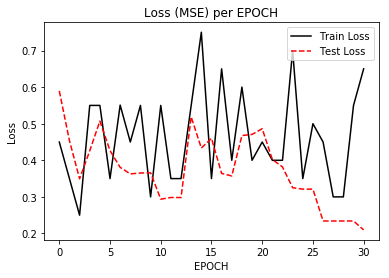

In [28]:
## Loss
import matplotlib.pyplot as plt
plt.plot(loss_vec, 'k-', label='Train Loss') 
plt.plot(test_loss, 'r--', label='Test Loss') 
plt.title('Loss (MSE) per EPOCH') 
plt.xlabel('EPOCH')
plt.ylabel('Loss') 
plt.legend(loc='upper right') 
plt.show()

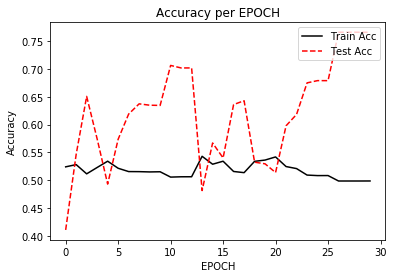

In [29]:
## Accuracy
plt.plot(train_acc, 'k-', label='Train Acc') 
plt.plot(test_acc, 'r--', label='Test Acc') 
plt.title('Accuracy per EPOCH') 
plt.xlabel('EPOCH')
plt.ylabel('Accuracy') 
plt.legend(loc='upper right') 
plt.show()

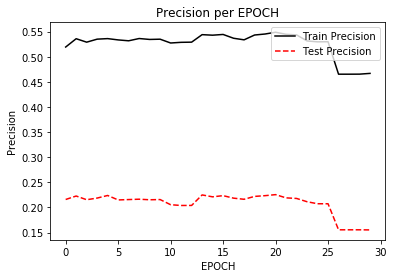

Final Precision: 0.1553672316384181


In [30]:
## Precision
plt.plot(train_precision, 'k-', label='Train Precision') 
plt.plot(test_precision, 'r--', label='Test Precision') 
plt.title('Precision per EPOCH') 
plt.xlabel('EPOCH')
plt.ylabel('Precision') 
plt.legend(loc='upper right') 
plt.show()
print("Final Precision: {}".format(test_precision[-1]))

In [24]:
loss_vec, test_loss = my_ae_model.get_ae_loss_vec()

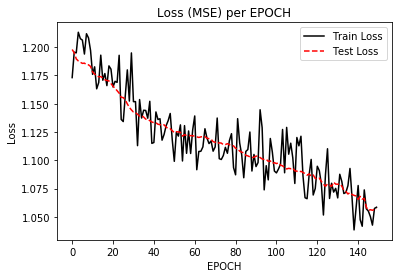

In [25]:
plt.plot(loss_vec, 'k-', label='Train Loss') 
plt.plot(test_loss, 'r--', label='Test Loss') 
plt.title('Loss (MSE) per EPOCH') 
plt.xlabel('EPOCH')
plt.ylabel('Loss') 
plt.legend(loc='upper right') 
plt.show()